## Queries to select specific data

In [ ]:
import sqlite3
import pandas as pd

# Connect to the SQLite database 
conn = sqlite3.connect(r'C:\.....\PPMDBSQLite.db')

# Create the SQL query string using the join method on the list
query_01 = f"""
SELECT PROJ_ID, PROJ_SHORT_NAME
FROM PROJECT
WHERE PROJ_SHORT_NAME = 'EC00501'
"""

query_02 = f"""
SELECT TASK_ID, PROJ_ID, WBS_ID, PHYS_COMPLETE_PCT, TASK_CODE, TASK_NAME, TASK_TYPE, 
    TOTAL_FLOAT_HR_CNT, FREE_FLOAT_HR_CNT, REMAIN_DRTN_HR_CNT,
    ACT_WORK_QTY, REMAIN_WORK_QTY, TARGET_WORK_QTY,
    TARGET_START_DATE, TARGET_END_DATE, ACT_START_DATE, ACT_END_DATE
FROM TASK
WHERE PROJ_ID = '4366'
"""

query_03 = f"""
SELECT WBS_ID, PROJ_ID, WBS_SHORT_NAME, WBS_NAME, PARENT_WBS_ID
FROM PROJWBS
WHERE PROJ_ID = '4366'
"""

query_04 = f"""
SELECT TASK_PRED_ID, TASK_ID, PRED_TASK_ID, PROJ_ID, PRED_PROJ_ID, PRED_TYPE
FROM TASKPRED
WHERE PROJ_ID = '4366'
"""


query_05 = f"""
SELECT FIN_DATES_ID, FIN_DATES_NAME, START_DATE, END_DATE
FROM FINDATES
"""

query_06 = f"""
SELECT FIN_DATES_ID, TASK_ID, PROJ_ID, ACT_WORK_QTY, ACT_WORK_COST, ACT_EQUIP_QTY, ACT_EQUIP_COST, ACT_MAT_COST, ACT_EXPENSE_COST, BCWP, PERFM_WORK_QTY, BCWS, SCHED_WORK_QTY
FROM TASKFIN
WHERE PROJ_ID = '4366'
"""

# Execute the SQL query and load results into a DataFrame
df_project_id = pd.read_sql_query(query_01, conn)
df_task = pd.read_sql_query(query_02, conn)
df_wbs = pd.read_sql_query(query_03, conn)
df_predecesor = pd.read_sql_query(query_04, conn)
df_period = pd.read_sql_query(query_05, conn)
df_ev = pd.read_sql_query(query_06, conn)


# Close the database connection
conn.close()



In [180]:
df_project_id

,PROJ_ID,PROJ_SHORT_NAME
0,4366,EC00501


In [181]:
df_ev.head()

,FIN_DATES_ID,TASK_ID,PROJ_ID,ACT_WORK_QTY,ACT_WORK_COST,ACT_EQUIP_QTY,ACT_EQUIP_COST,ACT_MAT_COST,ACT_EXPENSE_COST,BCWP,PERFM_WORK_QTY,BCWS,SCHED_WORK_QTY
0,202,95444,4366,65.000000,3575.000000,0.0,0.0,0.0,0.000000,3252.48,59.136,4620.00000,84.0
1,202,95482,4366,93.000000,5115.000000,0.0,0.0,0.0,0.000000,5895.12,107.184,4620.00000,84.0
2,202,95497,4366,159.999999,8533.333333,0.0,0.0,0.0,323.809524,6920.00,126.000,7249.52381,132.0
3,202,95498,4366,315.000000,14175.000000,0.0,0.0,0.0,476.190476,16436.00,352.800,17330.47619,372.0
4,204,95443,4366,22.000000,1210.000000,0.0,0.0,0.0,0.000000,1478.40,26.880,1430.00000,26.0


In [182]:
# Group the EV information 
df_EV = df_ev.groupby(['FIN_DATES_ID']).agg({'ACT_WORK_COST':'sum','ACT_EXPENSE_COST':'sum','ACT_EQUIP_COST':'sum','ACT_MAT_COST':'sum','BCWP':'sum','BCWS':'sum'}).reset_index()

In [183]:
# Merge the dataframe with the periods table
df_EV = pd.merge(df_EV, df_period, how='inner', on='FIN_DATES_ID')

df_EV['START_DATE'] = pd.to_datetime(df_EV['START_DATE'])

df_EV = df_EV.sort_values(by='START_DATE')

In [184]:
# Sum actual cost columns
df_EV['ACWP'] = df_EV['ACT_WORK_COST'] + df_EV['ACT_EXPENSE_COST']

In [185]:
# Sum actual cost columns
df_EV['ACWP_cumm'] = df_EV['ACWP'].cumsum()
df_EV['BCWP_cumm'] = df_EV['BCWP'].cumsum()
df_EV['BCWS_cumm'] = df_EV['BCWS'].cumsum()



In [186]:
df_EV = df_EV[['START_DATE','ACWP','BCWP','BCWS','ACWP_cumm','BCWP_cumm','BCWS_cumm']].reset_index()
df_EV

,index,START_DATE,ACWP,BCWP,BCWS,ACWP_cumm,BCWP_cumm,BCWS_cumm
0,7,2010-09-01,9600.000000,10080.000000,10560.00000,9600.000000,10080.000000,10560.00000
1,6,2010-10-01,10200.000000,12715.377778,10080.00000,19800.000000,22795.377778,20640.00000
2,5,2010-11-01,11400.000000,7711.200000,10560.00000,31200.000000,30506.577778,31200.00000
3,4,2010-12-01,42656.000000,40708.622222,42656.00000,73856.000000,71215.200000,73856.00000
4,3,2011-01-01,25845.000000,28098.000000,27414.00000,99701.000000,99313.200000,101270.00000
5,2,2011-02-01,23050.000000,23086.560000,22492.00000,122751.000000,122399.760000,123762.00000
6,1,2011-03-01,36817.857143,42013.680000,39550.47619,159568.857143,164413.440000,163312.47619
7,0,2011-04-01,32198.333333,32503.600000,33820.00000,191767.190476,196917.040000,197132.47619


### Add a top row

In [187]:
from datetime import datetime, timedelta


df = df_EV 

# Convert START_DATE column to datetime
df['START_DATE'] = pd.to_datetime(df['START_DATE'])

# Calculate the start of the previous month of the first row
first_row_date = df.loc[0, 'START_DATE']
start_previous_month = first_row_date.replace(day=1) - timedelta(days=1)
start_previous_month = start_previous_month.replace(day=1)

# Create a new row with all zeros except for the START_DATE column
new_row = pd.Series({
    'START_DATE': start_previous_month,
    'ACWP': 0,
    'BCWP': 0,
    'BCWS': 0,
    'ACWP_cumm': 0,
    'BCWP_cumm': 0,
    'BCWS_cumm': 0
})

# Append the new row to the dataframe
df = pd.concat([pd.DataFrame([new_row]), df], ignore_index=True)

# Drop the 'index' column if it exists
df.drop(columns=['index'], inplace=True, errors='ignore')

# Print the modified dataframe
df


,START_DATE,ACWP,BCWP,BCWS,ACWP_cumm,BCWP_cumm,BCWS_cumm
0,2010-08-01,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
1,2010-09-01,9600.000000,10080.000000,10560.00000,9600.000000,10080.000000,10560.00000
2,2010-10-01,10200.000000,12715.377778,10080.00000,19800.000000,22795.377778,20640.00000
3,2010-11-01,11400.000000,7711.200000,10560.00000,31200.000000,30506.577778,31200.00000
4,2010-12-01,42656.000000,40708.622222,42656.00000,73856.000000,71215.200000,73856.00000
5,2011-01-01,25845.000000,28098.000000,27414.00000,99701.000000,99313.200000,101270.00000
6,2011-02-01,23050.000000,23086.560000,22492.00000,122751.000000,122399.760000,123762.00000
7,2011-03-01,36817.857143,42013.680000,39550.47619,159568.857143,164413.440000,163312.47619
8,2011-04-01,32198.333333,32503.600000,33820.00000,191767.190476,196917.040000,197132.47619


In [188]:
# Initiatie the vector or EV location
indices = []
new_element = 0

PV_values = df['BCWS_cumm'].tolist()
EV_values = df['BCWP_cumm'].dropna().tolist()

# Find the EV location in the PV curve
for EV_location in EV_values:
    for i in range(len(PV_values) - 1):
        if PV_values[i] <= EV_location <= PV_values[i + 1]:
            indices.append(i)
            break
    else:
        indices.append(len(PV_values)-1)

In [189]:
indices

[0, 0, 2, 2, 3, 4, 5, 7, 7]

In [190]:
# Inititate the column ES in 0
df['ES'] = 0

# Calcualte ES
for i in range(len(EV_values) -1):
    j = indices[i]
    df['ES'].iloc[i] = j + (df['BCWP_cumm'].iloc[i] - df['BCWS_cumm'].iloc[j] ) / (df['BCWS_cumm'].iloc[j+1] - df['BCWS_cumm'].iloc[j] ) 


# Declare the PV in months
df['PV_month'] =0
for i in range (len(df)):
    df['PV_month'].iloc[i] = i



C:\Users\efloresmendoza\AppData\Local\Temp\ipykernel_9732\3407484562.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['ES'].iloc[i] = j + (df['BCWP_cumm'].iloc[i] - df['BCWS_cumm'].iloc[j] ) / (df['BCWS_cumm'].iloc[j+1] - df['BCWS_cumm

In [191]:
# Inititate the column SV_weeks in 0
df['SV_weeks'] =0

# Calcualte the Schedule Variance in weeks
for i in range(len(EV_values) -1):
    df['SV_weeks'].iloc[i] = (df['ES'].iloc[i] - df['PV_month'].iloc[i])*4.2

df

C:\Users\efloresmendoza\AppData\Local\Temp\ipykernel_9732\412417393.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['SV_weeks'].iloc[i] = (df['ES'].iloc[i] - df['PV_month'].iloc[i])*4.2
C:\Users\efloresmendoza\AppData\Local\Temp\ipyke

,START_DATE,ACWP,BCWP,BCWS,ACWP_cumm,BCWP_cumm,BCWS_cumm,ES,PV_month,SV_weeks
0,2010-08-01,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0,0.000000
1,2010-09-01,9600.000000,10080.000000,10560.00000,9600.000000,10080.000000,10560.00000,0.954545,1,-0.190909
2,2010-10-01,10200.000000,12715.377778,10080.00000,19800.000000,22795.377778,20640.00000,2.204108,2,0.857253
3,2010-11-01,11400.000000,7711.200000,10560.00000,31200.000000,30506.577778,31200.00000,2.934335,3,-0.275793
4,2010-12-01,42656.000000,40708.622222,42656.00000,73856.000000,71215.200000,73856.00000,3.938091,4,-0.260019
5,2011-01-01,25845.000000,28098.000000,27414.00000,99701.000000,99313.200000,101270.00000,4.928620,5,-0.299794
6,2011-02-01,23050.000000,23086.560000,22492.00000,122751.000000,122399.760000,123762.00000,5.939434,6,-0.254375
7,2011-03-01,36817.857143,42013.680000,39550.47619,159568.857143,164413.440000,163312.47619,7.032554,7,0.136725
8,2011-04-01,32198.333333,32503.600000,33820.00000,191767.190476,196917.040000,197132.47619,0.000000,8,0.000000


### S curve

In [192]:
cost_type_columns = ['ACWP_cumm','BCWP_cumm','BCWS_cumm']

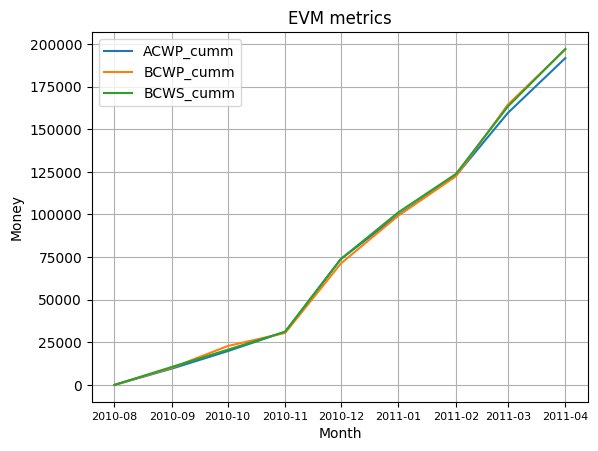

In [193]:
import matplotlib.pyplot as plt

# Rest of the code remains the same
plt.figure()
for cost_type in cost_type_columns:
    plt.plot(df['START_DATE'], df[cost_type], label=cost_type)
plt.title('EVM metrics')
plt.xlabel('Month')
plt.ylabel('Money')
plt.grid(True)
plt.legend()
plt.xticks(fontsize = 8)
plt.show()